In [457]:
# =========================
# 0) Install deps (Kaggle / Colab)
# =========================
# If you're on Kaggle, you can run this in a notebook cell.
!pip -q install opencv-python-headless scikit-learn mlxtend tqdm scikit-image kagglehub


13623.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [458]:
# =========================
# 1) Imports
# =========================
import os
import glob
import random
import time
from typing import Dict, Iterable, List, Sequence, Set, Tuple

import numpy as np
import cv2
from tqdm import tqdm

from sklearn.cluster import MiniBatchKMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from skimage.feature import local_binary_pattern


In [ ]:
# =========================
# A) Config + reproducibility
# =========================
MODE = "quick"  # "quick" or "full"
SEED = 0

# Dataset path (file or folder)
PATH_RAW = "/Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1/"
DATA_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# Image preprocessing
IMG_SIZE = (256, 256)
PATCH = 32

# Clustering
K = 150
KMEANS_BATCH_SIZE = 4096
KMEANS_RANDOM_STATE = 0
PATCHES_PER_IMAGE = 32

# Association rule mining
NEIGH = 1
MIN_SUPPORT = 0.002
MIN_CONF = 0.2
MIN_SYM_CONF = 0.0  # stopping threshold for avg symmetric confidence
MERGE_ITERS = 10
METRICS_EVERY = 1  # compute metrics every N merges
CONF_CURVE_EVERY = 1

# Dense/sparse mining controls (explicit, never silent)
USE_SPARSE_TE = True
MAX_DENSE_CELLS = 25_000_000  # if n_tx * n_items exceeds this, use sparse
ITEM_FILTER_TOP_N = None  # set to int to keep only top-N items (explicit)

# Pairwise sim / discriminative power controls
PAIRWISE_SAMPLE_PAIRS = 50000  # <=0 for exact only
PAIRWISE_EXACT_MAX_DOCS = 400
DISC_POWER_SAMPLE_SIZE = None  # set to int to sample objects; None => exact

# Output and visualization
OUTPUT_DIR = "./outputs_assocphrases"
FIG_SUBDIR = "paper_figures"
WORD_LUT_SEED = 42
ALPHA = 0.45
N_SHOW_LIMIT = 12
N_VIZ_LIMIT = 30
N_CROP_VIZ_LIMIT = 80
N_OVERLAY_LIMIT = 30

# Quick/full overrides
if MODE == "quick":
    MAX_IMAGES = 300
    K = 100
    PATCHES_PER_IMAGE = 48
    MERGE_ITERS = 25
    MIN_SUPPORT = 0.003
else:
    MAX_IMAGES = 300

random.seed(SEED)
np.random.seed(SEED)

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [460]:
# =========================
# B) Data loading + sampling
# =========================

def find_images(root: str) -> List[str]:
    '''Collect all image paths under root.'''
    paths: List[str] = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(DATA_EXTS):
                paths.append(os.path.join(dirpath, fn))
    return paths

path = os.path.normpath(os.path.expanduser(PATH_RAW))
if os.path.isfile(path):
    path = os.path.dirname(path)
if not os.path.exists(path):
    raise FileNotFoundError(f"Path does not exist: {path}")

print("Path to dataset files:", path)
image_paths = find_images(path)
print("Found images:", len(image_paths))

random.shuffle(image_paths)
image_paths_small = image_paths[: min(MAX_IMAGES, len(image_paths))]


def load_image_bgr(path: str, size: Tuple[int, int] = IMG_SIZE) -> np.ndarray:
    '''Load and resize an image to IMG_SIZE.'''
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

start = time.time()
imgs: List[np.ndarray] = []
kept_paths: List[str] = []
for p in tqdm(image_paths_small):
    im = load_image_bgr(p)
    if im is not None:
        imgs.append(im)
        kept_paths.append(p)

print("Loaded:", len(imgs), "in", round(time.time() - start, 2), "s")


Path to dataset files: /Users/dylesm/.cache/kagglehub/datasets/vesuvius13/formula-one-cars/versions/1
Found images: 2409


100%|██████████| 120/120 [00:02<00:00, 55.15it/s]

Loaded: 120 in 2.18 s


In [461]:
# =========================
# C) Patch extraction
# =========================

def image_to_patches(img_bgr: np.ndarray, patch: int = PATCH) -> Tuple[List[np.ndarray], List[Tuple[int, int]], Tuple[int, int]]:
    '''Split image into square patches and return (patches, coords, grid_shape).'''
    h, w = img_bgr.shape[:2]
    assert h % patch == 0 and w % patch == 0, "Image size must be divisible by patch size"
    patches: List[np.ndarray] = []
    coords: List[Tuple[int, int]] = []
    for y in range(0, h, patch):
        for x in range(0, w, patch):
            patches.append(img_bgr[y:y+patch, x:x+patch])
            coords.append((y // patch, x // patch))
    return patches, coords, (h // patch, w // patch)

patches0, coords0, grid0 = image_to_patches(imgs[0])
print("Patches:", len(patches0), "Grid:", grid0)


Patches: 64 Grid: (8, 8)


In [462]:
# =========================
# D1) Feature extraction config (HSV)
# =========================
HSV_H_BINS = 8
HSV_S_BINS = 8
HSV_V_BINS = 8


In [463]:
# =========================
# D2) Feature extraction config (LBP)
# =========================
LBP_P = 8
LBP_R = 1
LBP_METHOD = "uniform"
LBP_BINS = LBP_P + 2


In [464]:
# =========================
# D) Feature extraction
# =========================

def hsv_hist(patch_bgr: np.ndarray, h_bins: int = HSV_H_BINS, s_bins: int = HSV_S_BINS, v_bins: int = HSV_V_BINS) -> np.ndarray:
    '''HSV histogram normalized to sum to 1.'''
    hsv = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [h_bins, s_bins, v_bins], [0, 180, 0, 256, 0, 256])
    hist = hist.flatten().astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist


def lbp_hist(patch_bgr: np.ndarray) -> np.ndarray:
    '''Local Binary Pattern histogram normalized to sum to 1.'''
    gray = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=LBP_P, R=LBP_R, method=LBP_METHOD)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_BINS + 1), range=(0, LBP_BINS))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist


def avg_color_bgr(patch_bgr: np.ndarray) -> np.ndarray:
    '''Average BGR color normalized to [0,1].'''
    mean = patch_bgr.reshape(-1, 3).mean(axis=0).astype(np.float32) / 255.0
    return mean


def bright_dark_spots(patch_bgr: np.ndarray) -> np.ndarray:
    '''Brightest and darkest intensity normalized to [0,1].'''
    gray = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2GRAY)
    return np.array([gray.max() / 255.0, gray.min() / 255.0], dtype=np.float32)


def patch_features(patch_bgr: np.ndarray) -> np.ndarray:
    '''Concatenate color, texture, and intensity descriptors for a patch.'''
    return np.concatenate(
        [hsv_hist(patch_bgr), lbp_hist(patch_bgr), avg_color_bgr(patch_bgr), bright_dark_spots(patch_bgr)],
        axis=0
    )

feat0 = patch_features(patches0[0])
print("Feature dim:", feat0.shape)


Feature dim: (522,)


In [465]:
# =========================
# E) Visual-word quantization (k-means)
# =========================

def build_feature_matrix(imgs: Sequence[np.ndarray]) -> np.ndarray:
    '''Build feature matrix from patches across images.'''
    all_feats: List[np.ndarray] = []
    for img in tqdm(imgs):
        patches, _, _ = image_to_patches(img)
        idxs = list(range(len(patches)))
        if len(idxs) > PATCHES_PER_IMAGE:
            idxs = random.sample(idxs, PATCHES_PER_IMAGE)
        for j in idxs:
            all_feats.append(patch_features(patches[j]))
    return np.vstack(all_feats)

start = time.time()
X = build_feature_matrix(imgs)
print("Total patch samples:", X.shape, "in", round(time.time() - start, 2), "s")

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=KMEANS_BATCH_SIZE,
    random_state=KMEANS_RANDOM_STATE
)
kmeans.fit(X)
print("Trained kmeans with K =", K)


def image_words_grid(img_bgr: np.ndarray, patch: int = PATCH) -> np.ndarray:
    '''Assign a word ID to each patch.'''
    patches, _, (gh, gw) = image_to_patches(img_bgr, patch=patch)
    feats = np.vstack([patch_features(p) for p in patches])
    words = kmeans.predict(feats)
    grid = words.reshape(gh, gw)
    return grid

word_grids: List[np.ndarray] = []
for img in tqdm(imgs):
    word_grids.append(image_words_grid(img))

print("Example grid shape:", word_grids[0].shape)


100%|██████████| 120/120 [00:00<00:00, 233.91it/s]


Total patch samples: (5760, 522) in 0.52 s
Trained kmeans with K = 100


100%|██████████| 120/120 [00:00<00:00, 173.94it/s]

Example grid shape: (8, 8)


In [466]:
# =========================
# F) Transaction building (local windows)
# =========================

def local_transactions_from_grid(grid: np.ndarray, neigh: int = NEIGH) -> List[List[str]]:
    '''Create transactions from local neighborhoods in a grid.'''
    gh, gw = grid.shape
    tx: List[List[str]] = []
    for r in range(gh):
        for c in range(gw):
            r0, r1 = max(0, r - neigh), min(gh, r + neigh + 1)
            c0, c1 = max(0, c - neigh), min(gw, c + neigh + 1)
            window = grid[r0:r1, c0:c1].ravel()
            items = list(set(int(x) for x in window))
            items = [f"w{it}" for it in items]
            tx.append(items)
    return tx


def build_transactions_per_image(word_grids: Sequence[np.ndarray], neigh: int = NEIGH) -> List[List[List[str]]]:
    '''Build transactions for each image.'''
    return [local_transactions_from_grid(grid, neigh=neigh) for grid in word_grids]

start = time.time()
transactions_per_image = build_transactions_per_image(word_grids, neigh=NEIGH)
transactions = [t for tx in transactions_per_image for t in tx]
print("Total transactions:", len(transactions), "in", round(time.time() - start, 2), "s")
print("Example transaction:", transactions[0][:5])


Total transactions: 7680 in 0.02 s
Example transaction: ['w8', 'w21', 'w15']


In [467]:
# =========================
# G) Rule mining
# =========================

def mine_rules(transactions: Sequence[Sequence[str]], min_support: float, min_conf: float) -> Tuple[object, object]:
    '''Mine frequent itemsets and association rules.'''
    items = sorted({i for tx in transactions for i in tx})
    if ITEM_FILTER_TOP_N is not None:
        counts = {i: 0 for i in items}
        for tx in transactions:
            for i in set(tx):
                counts[i] += 1
        top_items = set(sorted(counts, key=counts.get, reverse=True)[:ITEM_FILTER_TOP_N])
        transactions = [[i for i in tx if i in top_items] for tx in transactions]
        items = sorted(top_items)
        print(f"[WARN] ITEM_FILTER_TOP_N enabled -> keeping {len(items)} items")

    te = TransactionEncoder()
    use_sparse = USE_SPARSE_TE
    if len(transactions) * max(1, len(items)) > MAX_DENSE_CELLS:
        use_sparse = True
        print("[INFO] Using sparse TransactionEncoder due to size")

    T = te.fit(transactions).transform(transactions, sparse=use_sparse)
    import pandas as pd
    df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)

    freq = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=min_conf)
    rules = rules.sort_values(["confidence", "lift", "support"], ascending=False)
    return freq, rules


def is_singleton(fs: object) -> bool:
    return isinstance(fs, (set, frozenset)) and len(fs) == 1


def extract_pair_rules(rules_df) -> object:
    '''Filter rules with single-item antecedent and consequent.'''
    return rules_df[
        rules_df["antecedents"].apply(is_singleton) &
        rules_df["consequents"].apply(is_singleton)
    ].copy()


def best_symmetric_pair(pair_rules) -> Tuple[float, float, str, str]:
    '''Return (avg_conf, support, a, b) for best symmetric pair, or None.'''
    conf_map: Dict[Tuple[str, str], float] = {}
    sup_map: Dict[Tuple[str, str], float] = {}
    for _, row in pair_rules.iterrows():
        a = next(iter(row["antecedents"]))
        b = next(iter(row["consequents"]))
        conf_map[(a, b)] = float(row["confidence"])
        sup_map[(a, b)] = float(row["support"])

    best = None
    for (a, b), cab in conf_map.items():
        cba = conf_map.get((b, a))
        if cba is None:
            continue
        avg_conf = 0.5 * (cab + cba)
        sup = 0.5 * (sup_map.get((a, b), 0.0) + sup_map.get((b, a), 0.0))
        if (best is None) or (avg_conf > best[0]):
            best = (avg_conf, sup, a, b)
    return best

start = time.time()
_, rules = mine_rules(transactions, MIN_SUPPORT, MIN_CONF)
pair_rules = extract_pair_rules(rules)
print("Rules:", len(rules), "Pair rules:", len(pair_rules), "in", round(time.time() - start, 2), "s")


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Rules: 1222 Pair rules: 345 in 1.03 s


In [468]:
# =========================
# H) Symmetric merge loop
# =========================

def doc_sets_from_transactions(tx_per_image: Sequence[Sequence[Sequence[str]]]) -> List[Set[str]]:
    '''Build per-image document token sets from transactions.'''
    doc_sets: List[Set[str]] = []
    for tx in tx_per_image:
        s: Set[str] = set()
        for items in tx:
            s.update(items)
        doc_sets.append(s)
    return doc_sets


def apply_merge_to_tx_per_image(tx_per_image: Sequence[Sequence[Sequence[str]]], a: str, b: str, new_token: str) -> Tuple[List[List[List[str]]], int]:
    '''Apply merge to all transactions per image; returns (new_tx, changed_count).'''
    out: List[List[List[str]]] = []
    changed = 0
    for tx in tx_per_image:
        out_tx: List[List[str]] = []
        for items in tx:
            s = set(items)
            if a in s and b in s:
                s.remove(a); s.remove(b)
                s.add(new_token)
                changed += 1
            out_tx.append(list(s))
        out.append(out_tx)
    return out, changed


def apply_merge_to_doc_sets(doc_sets: Sequence[Set[str]], a: str, b: str, new_token: str) -> List[Set[str]]:
    '''Apply merge to per-image token sets.'''
    out: List[Set[str]] = []
    for s in doc_sets:
        s2 = set(s)
        if a in s2 and b in s2:
            s2.remove(a); s2.remove(b)
            s2.add(new_token)
        out.append(s2)
    return out


def merge_loop(tx_per_image: Sequence[Sequence[Sequence[str]]], iters: int) -> Tuple[List[Dict], List[Set[str]]]:
    '''Run symmetric merges and return iteration logs and final doc sets.'''
    logs: List[Dict] = []
    current_tx = tx_per_image
    current_docs = doc_sets_from_transactions(current_tx)
    phrase_members: Dict[str, Set[int]] = {}

    def token_members(token: str) -> Set[int]:
        if token.startswith("w"):
            return {int(token[1:])}
        return set(phrase_members.get(token, set()))

    for t in range(iters + 1):
        tx_flat = [t for tx in current_tx for t in tx]
        _, rules_df = mine_rules(tx_flat, MIN_SUPPORT, MIN_CONF)
        pair_rules = extract_pair_rules(rules_df)
        best = best_symmetric_pair(pair_rules)

        vocab_size = len(set().union(*current_docs)) if current_docs else 0
        log_row = {
            "iter": t,
            "num_rules": int(len(rules_df)),
            "num_pair_rules": int(len(pair_rules)),
            "vocab_size": int(vocab_size),
            "best_pair": None,
            "avg_sym_conf": None,
            "support": None,
            "tx_changed": 0,
            "new_token": None,
            "members": None,
        }

        if best is None or t == iters:
            logs.append(log_row)
            print(f"Iter {t}: stop (no symmetric pair or max iters)")
            break

        avg_conf, sup, a, b = best
        if avg_conf < MIN_SYM_CONF:
            logs.append(log_row)
            print(f"Iter {t}: stop (avg_sym_conf {avg_conf:.3f} < MIN_SYM_CONF)")
            break

        new_token = f"p{t}({a}+{b})"
        members = sorted(token_members(a) | token_members(b))
        current_tx, changed = apply_merge_to_tx_per_image(current_tx, a, b, new_token)
        current_docs = apply_merge_to_doc_sets(current_docs, a, b, new_token)

        phrase_members[new_token] = set(members)

        log_row.update({
            "best_pair": f"{a},{b}",
            "avg_sym_conf": float(avg_conf),
            "support": float(sup),
            "tx_changed": int(changed),
            "vocab_size": int(len(set().union(*current_docs)) if current_docs else 0),
            "new_token": new_token,
            "members": members,
        })
        logs.append(log_row)
        print(f"Iter {t}: merge {a}<->{b} avg_conf={avg_conf:.3f} support={sup:.4f} tx_changed={changed}")

    return logs, current_docs

start = time.time()
merge_logs, final_doc_sets = merge_loop(transactions_per_image, MERGE_ITERS)
print("Merge loop done in", round(time.time() - start, 2), "s")

# Map phrase token -> base word IDs
PHRASE_MEMBERS = {m["new_token"]: m["members"] for m in merge_logs if m.get("new_token")}
PHRASE_TOKENS = list(PHRASE_MEMBERS.keys())


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 0: merge w7<->w18 avg_conf=0.713 support=0.0065 tx_changed=50


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 1: merge w33<->w25 avg_conf=0.702 support=0.0043 tx_changed=33


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 2: merge w36<->w20 avg_conf=0.563 support=0.2480 tx_changed=1905


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 3: merge w27<->w56 avg_conf=0.538 support=0.0156 tx_changed=120


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 4: merge w47<->w2 avg_conf=0.531 support=0.0285 tx_changed=219


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 5: merge w10<->w30 avg_conf=0.529 support=0.0181 tx_changed=139


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 6: merge w47<->w97 avg_conf=0.508 support=0.0125 tx_changed=96


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 7: merge w19<->w79 avg_conf=0.508 support=0.0056 tx_changed=43


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 8: merge w91<->w23 avg_conf=0.482 support=0.0217 tx_changed=167


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 9: merge w61<->w11 avg_conf=0.479 support=0.0135 tx_changed=104


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 10: merge w24<->w12 avg_conf=0.461 support=0.0081 tx_changed=62


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 11: merge w12<->w76 avg_conf=0.516 support=0.0129 tx_changed=99


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 12: merge w26<->w83 avg_conf=0.454 support=0.0112 tx_changed=86


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 13: merge w63<->w75 avg_conf=0.450 support=0.0049 tx_changed=38


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 14: merge w54<->w86 avg_conf=0.441 support=0.0111 tx_changed=85


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 15: merge w9<->w1 avg_conf=0.426 support=0.0348 tx_changed=267


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 16: merge w81<->w72 avg_conf=0.410 support=0.0043 tx_changed=33


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 17: merge w17<->w59 avg_conf=0.406 support=0.0145 tx_changed=111


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 18: merge w41<->w58 avg_conf=0.398 support=0.0047 tx_changed=36


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 19: merge w64<->w46 avg_conf=0.388 support=0.0048 tx_changed=37


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 20: merge w97<->w8 avg_conf=0.365 support=0.0065 tx_changed=50


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 21: merge w71<->w8 avg_conf=0.549 support=0.0039 tx_changed=30


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 22: merge w9<->w40 avg_conf=0.357 support=0.0165 tx_changed=127


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 23: merge w91<->w4 avg_conf=0.350 support=0.0055 tx_changed=42


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 24: merge w15<->w20 avg_conf=0.335 support=0.0559 tx_changed=429


/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


Iter 25: stop (no symmetric pair or max iters)
Merge loop done in 18.39 s


<>:58: DeprecationWarning: invalid escape sequence '\ '
<>:58: DeprecationWarning: invalid escape sequence '\ '
/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/4183716311.py:58: DeprecationWarning: invalid escape sequence '\ '
  '''Average density(D) - density(D \ o) across objects.'''
/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


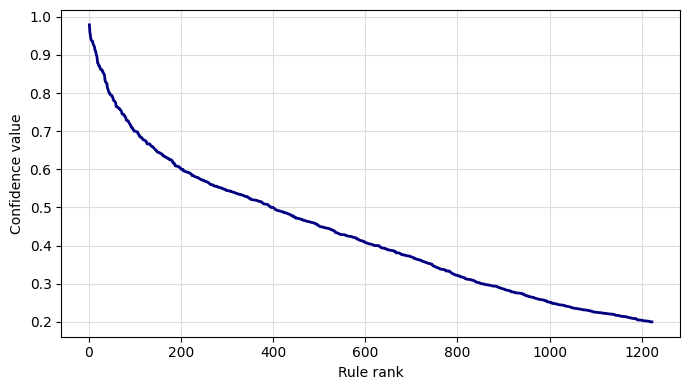

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


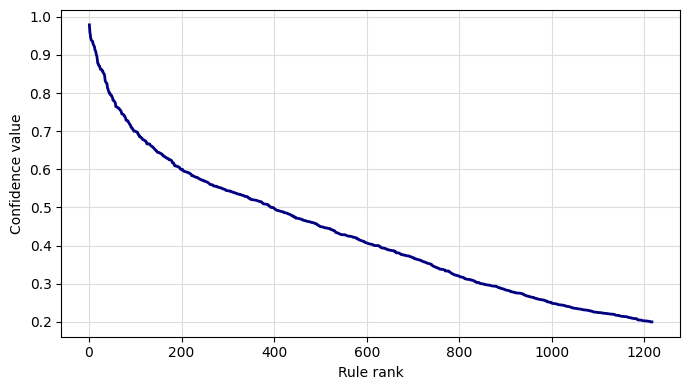

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


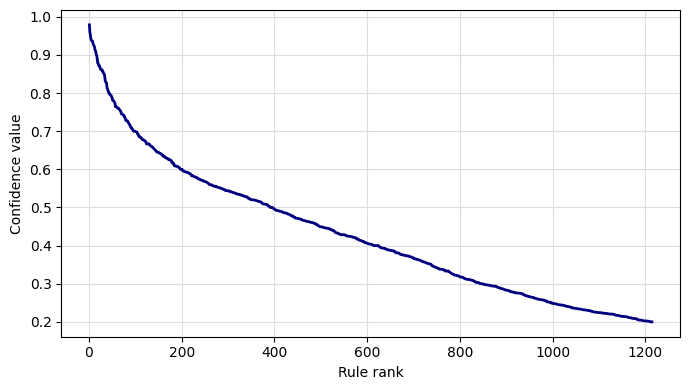

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


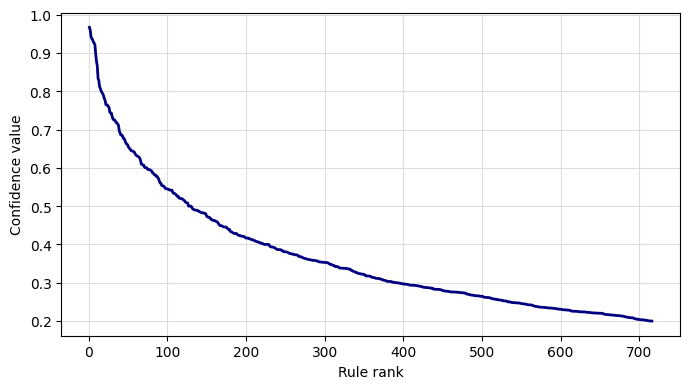

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


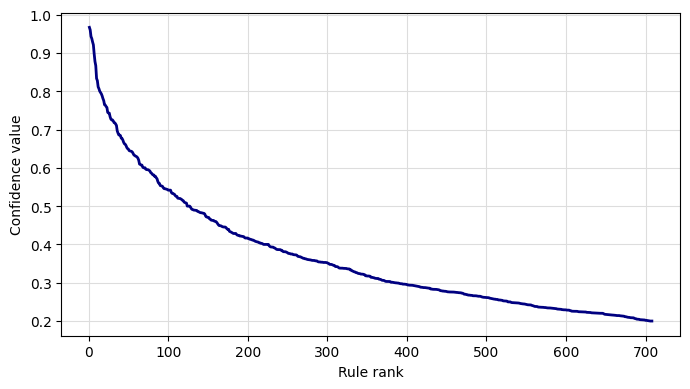

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


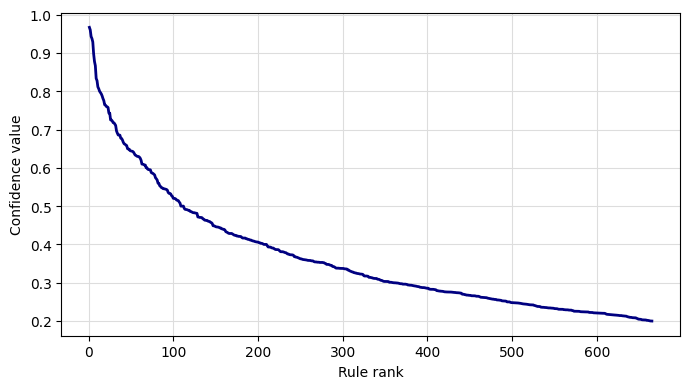

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


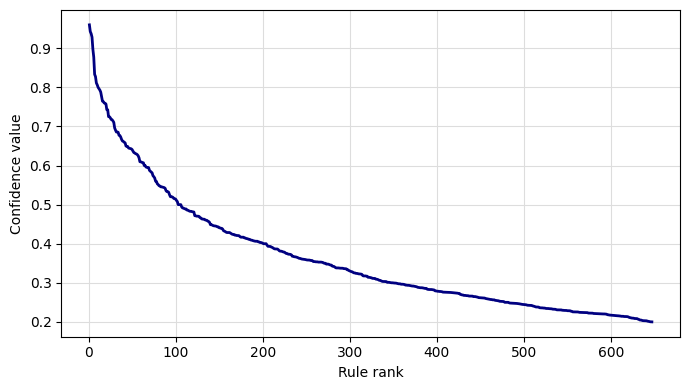

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


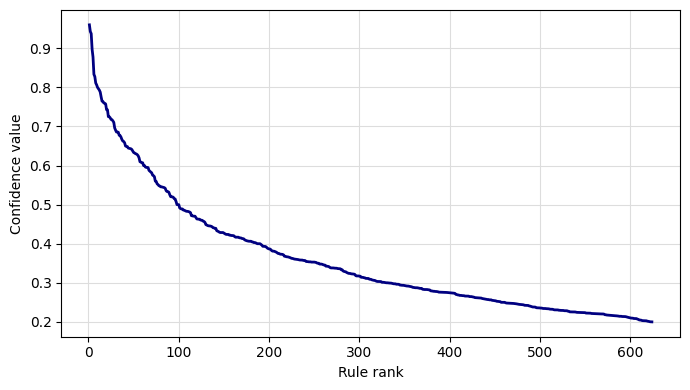

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


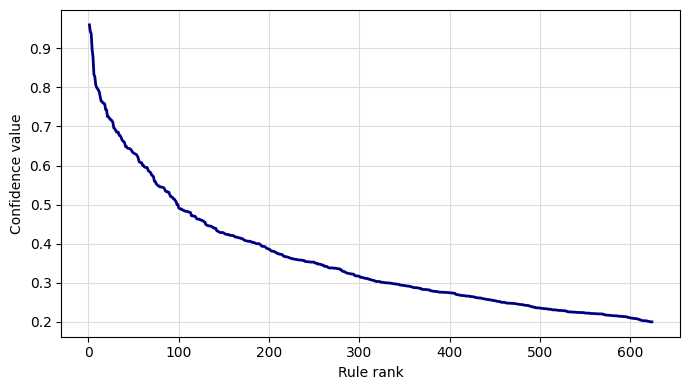

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


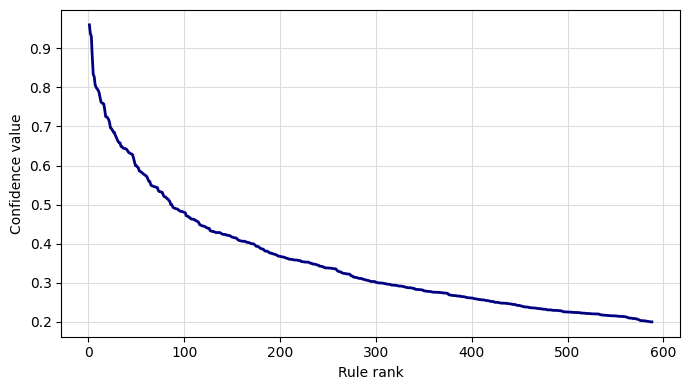

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


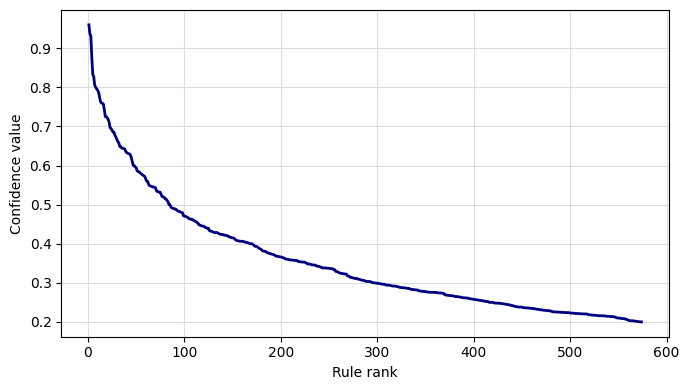

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


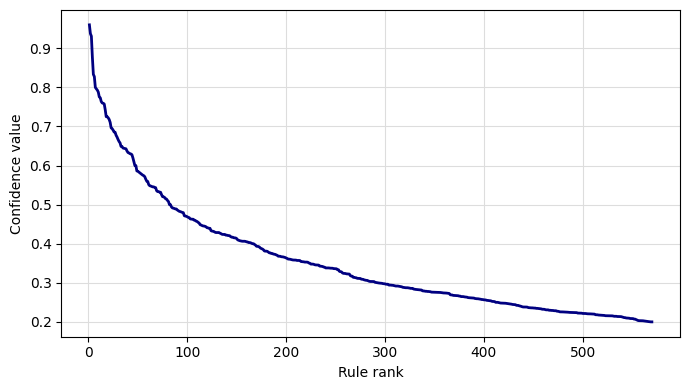

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


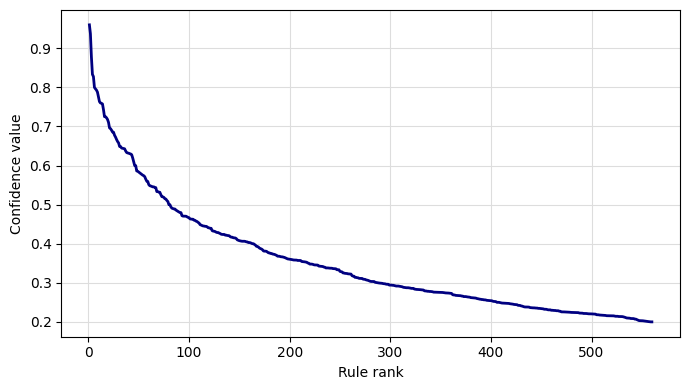

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


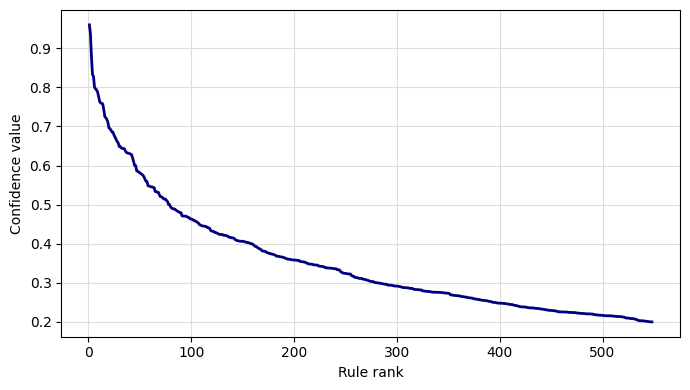

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


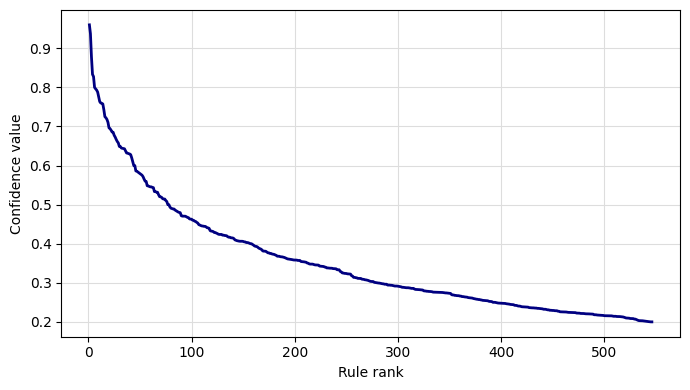

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


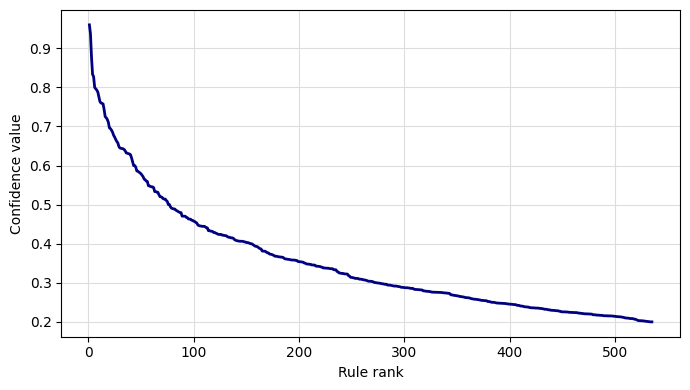

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


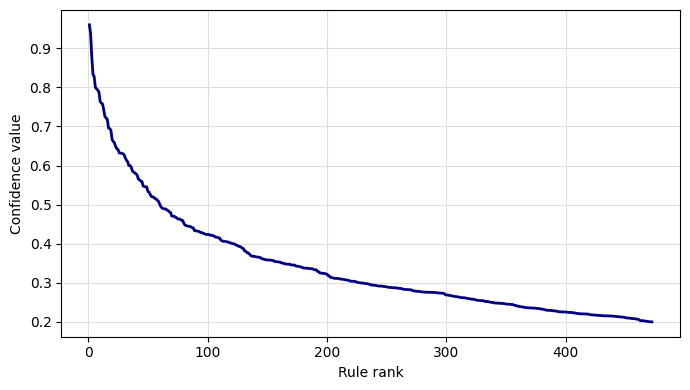

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


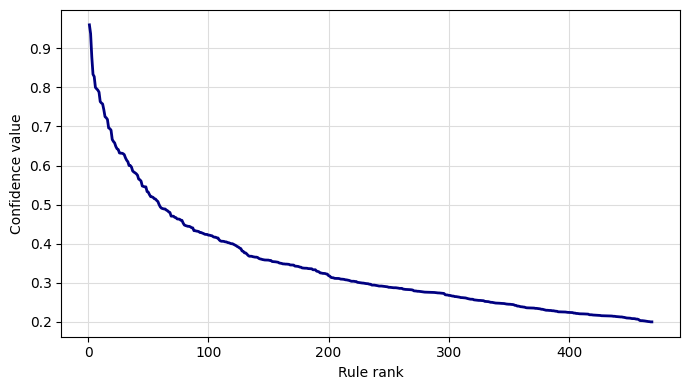

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


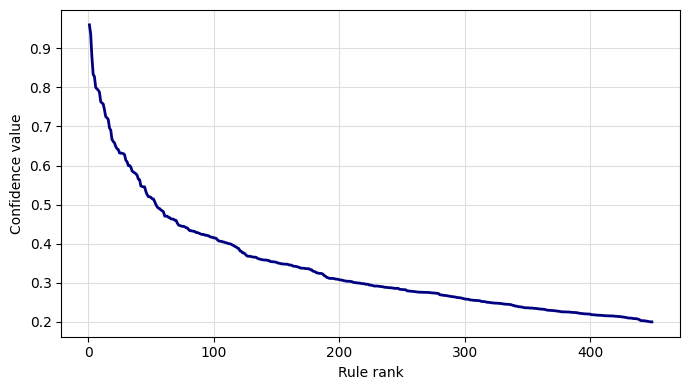

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


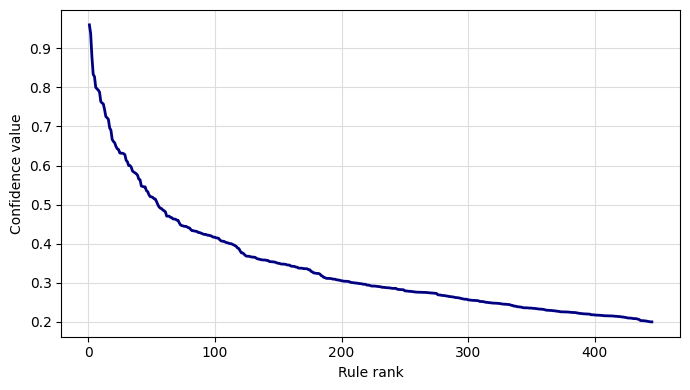

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


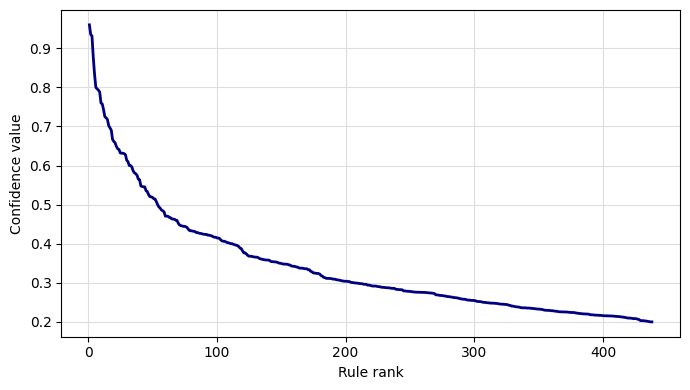

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


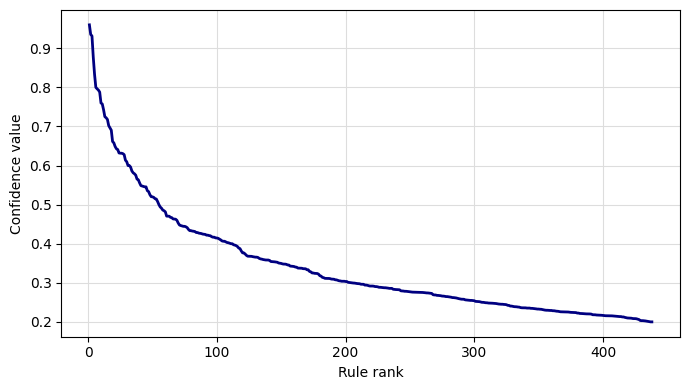

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


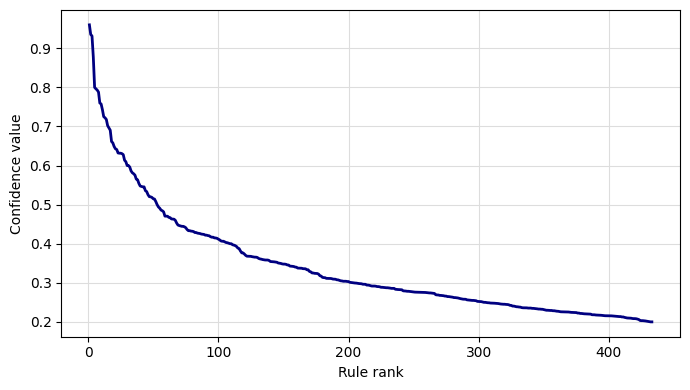

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


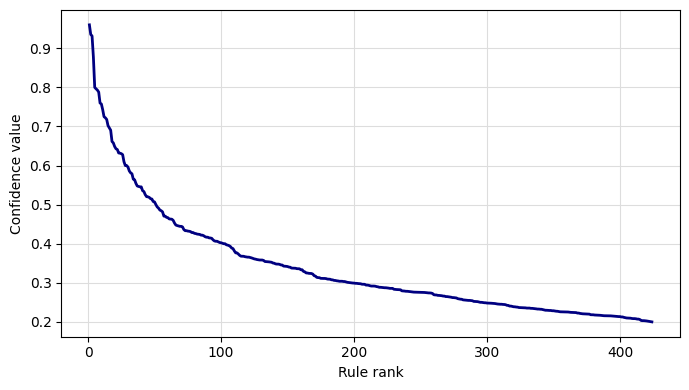

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


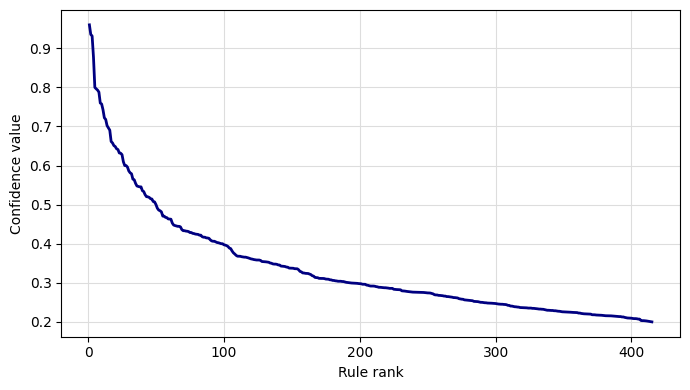

/var/folders/xx/37z511cj2fq2x3d7t5_023ww0000gn/T/ipykernel_10474/1075797498.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(T, columns=te.columns_) if use_sparse else pd.DataFrame(T, columns=te.columns_)


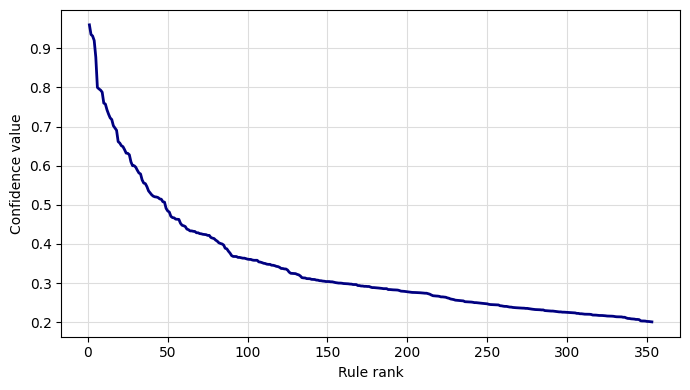

Saved metrics: ./outputs_assocphrases/metrics_over_merges.csv


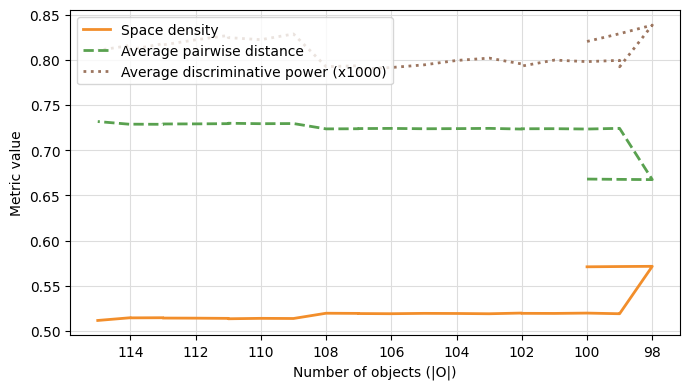

In [469]:
# =========================
# I) Evaluation + plots

from matplotlib.ticker import MaxNLocator
# =========================

def build_doc_matrix(doc_sets: Sequence[Set[str]]) -> Tuple[np.ndarray, List[str]]:
    '''Build binary document-term matrix for images.'''
    vocab = sorted(set().union(*doc_sets)) if doc_sets else []
    idx = {t: i for i, t in enumerate(vocab)}
    X = np.zeros((len(doc_sets), len(vocab)), dtype=np.float64)
    for i, s in enumerate(doc_sets):
        for t in s:
            X[i, idx[t]] = 1.0
    return X, vocab


def density_from_matrix(X: np.ndarray) -> float:
    '''Average cosine similarity between each document and the centroid.'''
    if X.size == 0:
        return 0.0
    eps = 1e-12
    norms = np.linalg.norm(X, axis=1) + eps
    Xn = X / norms[:, None]
    centroid = X.mean(axis=0)
    c_norm = np.linalg.norm(centroid) + eps
    sims = (Xn @ centroid) / c_norm
    return float(np.mean(sims))


def avg_pairwise_distance(X: np.ndarray, sample_pairs: int = PAIRWISE_SAMPLE_PAIRS) -> float:
    '''Average cosine distance (1 - similarity) for i<=j (exact if small, else sampled).'''
    n = X.shape[0]
    if n == 0:
        return 0.0
    eps = 1e-12
    norms = np.linalg.norm(X, axis=1) + eps
    Xn = X / norms[:, None]

    if n <= PAIRWISE_EXACT_MAX_DOCS or sample_pairs <= 0:
        sim = Xn @ Xn.T
        k = n * (n + 1) / 2.0
        total = (np.sum(sim) + np.sum(np.diag(sim))) / 2.0
        return float(1.0 - (total / k))

    rng = np.random.default_rng(SEED)
    sims = []
    for _ in range(sample_pairs):
        i = rng.integers(0, n)
        j = rng.integers(0, n)
        if j < i:
            i, j = j, i
        sims.append(float(np.dot(Xn[i], Xn[j])))
    return float(1.0 - np.mean(sims))


def avg_discriminative_power(X: np.ndarray) -> float:
    '''Average density(D) - density(D \ o) across objects.'''
    if X.size == 0:
        return 0.0
    density_full = density_from_matrix(X)
    m = X.shape[1]
    cols = list(range(m))
    if DISC_POWER_SAMPLE_SIZE is not None and DISC_POWER_SAMPLE_SIZE < m:
        rng = np.random.default_rng(SEED)
        cols = rng.choice(m, size=DISC_POWER_SAMPLE_SIZE, replace=False).tolist()
        print(f"[INFO] Discriminative power sampled: {len(cols)}/{m}")
    diffs = []
    for col in cols:
        X2 = X.copy()
        X2[:, col] = 0.0
        diffs.append(density_full - density_from_matrix(X2))
    return float(np.mean(diffs)) if diffs else 0.0


def plot_confidence_curve(rules_df, out_path: str) -> None:
    '''Plot Fig.3-style confidence curve.'''
    conf_vals = rules_df["confidence"].sort_values(ascending=False).values
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(np.arange(1, len(conf_vals) + 1), conf_vals, color="navy", lw=2)
    ax.set_xlabel("Rule rank")
    ax.set_ylabel("Confidence value")
    ax.grid(True, color="#dddddd", linewidth=0.8)
    fig.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.show()

def plot_metric_curves(metrics_rows: List[Dict], out_path: str) -> None:
    '''Plot Fig.4-style metric curves over merges vs |O|.'''
    x_vals = [r["vocab_size"] for r in metrics_rows]
    density = [r["density"] for r in metrics_rows]
    pairwise = [r["avg_pairwise_dist"] for r in metrics_rows]
    disc = [r["avg_disc"] for r in metrics_rows]
    disc_scaled = [d * 10000 for d in disc]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(x_vals, density, color="#f28e2b", lw=2, label="Space density")
    ax.plot(x_vals, pairwise, color="#59a14f", lw=2, ls="--", label="Average pairwise distance")
    ax.plot(x_vals, disc_scaled, color="#9c755f", lw=2, ls=":", label="Average discriminative power (x1000)")

    ax.set_xlabel("Number of objects (|O|)")
    ax.set_ylabel("Metric value")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.invert_xaxis()
    ax.grid(True, color="#dddddd", linewidth=0.8)
    ax.legend(loc="upper left")

    fig.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.show()

# ---- Evaluate per iteration (including iter 0) ----
metrics_rows: List[Dict] = []

current_tx = transactions_per_image
current_docs = doc_sets_from_transactions(current_tx)

for t in range(MERGE_ITERS + 1):
    tx_flat = [t for tx in current_tx for t in tx]
    _, rules_df = mine_rules(tx_flat, MIN_SUPPORT, MIN_CONF)
    pair_rules = extract_pair_rules(rules_df)

    if t % METRICS_EVERY == 0:
        X, _ = build_doc_matrix(current_docs)
        row = {
            "iter": t,
            "vocab_size": int(X.shape[1]),
            "density": density_from_matrix(X),
            "avg_pairwise_dist": avg_pairwise_distance(X),
            "avg_disc": avg_discriminative_power(X),
            "num_rules": int(len(rules_df)),
        }
        metrics_rows.append(row)

    if t % CONF_CURVE_EVERY == 0:
        fig_dir = os.path.join(OUTPUT_DIR, FIG_SUBDIR)
        os.makedirs(fig_dir, exist_ok=True)
        plot_confidence_curve(rules_df, os.path.join(fig_dir, f"fig3_confidence_iter{t:02d}.png"))

    best = best_symmetric_pair(pair_rules)
    if best is None or t == MERGE_ITERS:
        break
    avg_conf, sup, a, b = best
    if avg_conf < MIN_SYM_CONF:
        break
    new_token = f"p{t}({a}+{b})"
    current_tx, _ = apply_merge_to_tx_per_image(current_tx, a, b, new_token)
    current_docs = apply_merge_to_doc_sets(current_docs, a, b, new_token)

import pandas as pd
metrics_df = pd.DataFrame(metrics_rows)
metrics_csv = os.path.join(OUTPUT_DIR, "metrics_over_merges.csv")
metrics_df.to_csv(metrics_csv, index=False)
print("Saved metrics:", metrics_csv)

plot_metric_curves(metrics_rows, os.path.join(OUTPUT_DIR, FIG_SUBDIR, "fig4_metrics_over_merges.png"))


In [470]:
# =========================
# J) Visualization outputs (overlays/crops)
# =========================

def ensure_dir(p: str) -> str:
    os.makedirs(p, exist_ok=True)
    return p


def make_id_color_lut(n_ids: int, seed: int = 0) -> np.ndarray:
    '''Stable LUT so word colors are consistent across images.'''
    rng = np.random.default_rng(seed)
    lut = rng.integers(0, 256, size=(n_ids, 3), dtype=np.uint8)
    lut[0] = np.array([0, 0, 0], dtype=np.uint8)
    return lut

WORD_LUT = make_id_color_lut(K, seed=WORD_LUT_SEED)


def word_grid_to_mosaic(grid: np.ndarray, patch: int = PATCH, lut: np.ndarray = WORD_LUT) -> np.ndarray:
    gh, gw = grid.shape
    color_grid = lut[grid.astype(np.int32)]
    mosaic = np.repeat(np.repeat(color_grid, patch, axis=0), patch, axis=1)
    return mosaic


def overlay_word_mosaic(img_bgr: np.ndarray, word_grid: np.ndarray, patch: int = PATCH, lut: np.ndarray = WORD_LUT, alpha: float = 0.45) -> np.ndarray:
    H, W = img_bgr.shape[:2]
    gh, gw = word_grid.shape
    assert H == gh * patch and W == gw * patch, "Grid size must match image size"
    mosaic = word_grid_to_mosaic(word_grid, patch=patch, lut=lut).astype(np.float32)
    img_f = img_bgr.astype(np.float32)
    blended = (1 - alpha) * img_f + alpha * mosaic
    return blended.astype(np.uint8)


def phrase_hit_map(grid: np.ndarray, a_token: str, b_token: str, neigh: int = NEIGH) -> np.ndarray:
    a_id = int(a_token[1:])
    b_id = int(b_token[1:])
    gh, gw = grid.shape
    hit = np.zeros((gh, gw), dtype=bool)
    for r in range(gh):
        for c in range(gw):
            r0, r1 = max(0, r - neigh), min(gh, r + neigh + 1)
            c0, c1 = max(0, c - neigh), min(gw, c + neigh + 1)
            window = grid[r0:r1, c0:c1]
            hit[r, c] = bool(np.any(window == a_id) and np.any(window == b_id))
    return hit


def overlay_hits_on_image(img_bgr: np.ndarray, hit_map: np.ndarray, patch: int = PATCH, alpha: float = 0.4) -> np.ndarray:
    overlay = img_bgr.copy()
    gh, gw = hit_map.shape
    for r in range(gh):
        for c in range(gw):
            if not hit_map[r, c]:
                continue
            y0, y1 = r * patch, (r + 1) * patch
            x0, x1 = c * patch, (c + 1) * patch
            overlay[y0:y1, x0:x1] = (1 - alpha) * overlay[y0:y1, x0:x1] + alpha * np.array([0, 0, 255])
    return overlay.astype(np.uint8)

mosaic_dir = ensure_dir(os.path.join(OUTPUT_DIR, "word_mosaics"))
overlay_dir = ensure_dir(os.path.join(OUTPUT_DIR, "word_overlay"))
compare_dir = ensure_dir(os.path.join(OUTPUT_DIR, "word_overlay_compare"))
phrase_dir = ensure_dir(os.path.join(OUTPUT_DIR, "phrase_overlays"))
crops_dir = ensure_dir(os.path.join(OUTPUT_DIR, "phrase_crops"))

N_SHOW = min(N_SHOW_LIMIT, len(imgs))
for i in range(N_SHOW):
    grid = word_grids[i]
    mosaic = word_grid_to_mosaic(grid)
    cv2.imwrite(os.path.join(mosaic_dir, f"img_{i:04d}_word_mosaic.png"), mosaic)

N_OVERLAY = min(N_OVERLAY_LIMIT, len(imgs))
for i in range(N_OVERLAY):
    img = imgs[i]
    grid = word_grids[i]
    overlay = overlay_word_mosaic(img, grid, alpha=ALPHA)
    cv2.imwrite(os.path.join(overlay_dir, f"img_{i:04d}_word_overlay.png"), overlay)
    combined = np.hstack([img, overlay])
    cv2.imwrite(os.path.join(compare_dir, f"img_{i:04d}_compare.png"), combined)

if merge_logs:
    top_pairs = [m for m in merge_logs if m.get("best_pair")][:min(3, len(merge_logs))]
    for m in top_pairs:
        a, b = m["best_pair"].split(",")
        for i in range(min(N_VIZ_LIMIT, len(imgs))):
            grid = word_grids[i]
            hit = phrase_hit_map(grid, a, b, neigh=NEIGH)
            if hit.sum() == 0:
                continue
            overlay = overlay_hits_on_image(imgs[i], hit, patch=PATCH, alpha=0.4)
            cv2.imwrite(os.path.join(phrase_dir, f"img_{i:04d}_overlay_{a}_{b}.png"), overlay)
            hit_positions = np.argwhere(hit)
            if len(hit_positions) == 0:
                continue
            rng = np.random.default_rng(SEED)
            if len(hit_positions) > N_CROP_VIZ_LIMIT:
                hit_positions = hit_positions[rng.choice(len(hit_positions), size=N_CROP_VIZ_LIMIT, replace=False)]
            for j, (r, c) in enumerate(hit_positions[:8]):
                cy = r * PATCH + PATCH // 2
                cx = c * PATCH + PATCH // 2
                half = 2 * PATCH
                H, W = imgs[i].shape[:2]
                y0, y1 = max(0, cy - half), min(H, cy + half)
                x0, x1 = max(0, cx - half), min(W, cx + half)
                crop = imgs[i][y0:y1, x0:x1]
                cv2.imwrite(os.path.join(crops_dir, f"img_{i:04d}_crop_{a}_{b}_{j:02d}.png"), crop)

print("Saved outputs under:", OUTPUT_DIR)


Saved outputs under: ./outputs_assocphrases


In [ ]:
# =========================
# K) Phrase visual evaluation (semantic sanity check)
# =========================
import os
import math
import warnings
from typing import Iterable
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Adapter layer ----
def get_frame(frame_id: int) -> np.ndarray:
    # imgs are stored in BGR; return RGB for plotting
    if frame_id < 0 or frame_id >= len(imgs):
        raise IndexError(f'frame_id out of range: {frame_id}')
    return cv2.cvtColor(imgs[frame_id], cv2.COLOR_BGR2RGB)

def get_frame_path(frame_id: int) -> str:
    return kept_paths[frame_id] if frame_id < len(kept_paths) else ''

def get_phrase_members(phrase_id: str) -> list:
    # phrase_id is token like 'p0(w12+w87)'
    if phrase_id not in PHRASE_MEMBERS:
        raise KeyError(f'Unknown phrase_id: {phrase_id}')
    return list(PHRASE_MEMBERS[phrase_id])

def iter_phrase_occurrences(phrase_id: str, neigh: int = NEIGH):
    members = set(get_phrase_members(phrase_id))
    if not members:
        return
    for frame_id, grid in enumerate(word_grids):
        gh, gw = grid.shape
        for r in range(gh):
            for c in range(gw):
                r0, r1 = max(0, r - neigh), min(gh, r + neigh + 1)
                c0, c1 = max(0, c - neigh), min(gw, c + neigh + 1)
                window = grid[r0:r1, c0:c1]
                present = set(int(x) for x in np.unique(window)) & members
                if not present:
                    continue
                strength = len(present) / max(1, len(members))
                regions = []
                for rr in range(r0, r1):
                    for cc in range(c0, c1):
                        wid = int(grid[rr, cc])
                        if wid in present:
                            regions.append((rr, cc, wid))
                yield frame_id, regions, strength, len(present)

def _word_color(word_id: int) -> tuple:
    # Use WORD_LUT if available (BGR -> RGB), else deterministic hash color
    if 'WORD_LUT' in globals() and word_id < len(WORD_LUT):
        bgr = WORD_LUT[word_id]
        return int(bgr[2]), int(bgr[1]), int(bgr[0])
    rng = np.random.default_rng(word_id)
    color = rng.integers(64, 255, size=3).tolist()
    return tuple(int(c) for c in color)

def _draw_regions(img_rgb: np.ndarray, regions: list, patch: int = PATCH, alpha=0.35, border=2) -> np.ndarray:
    # regions contain (row, col, word_id)
    if not regions:
        return img_rgb.copy()
    overlay = img_rgb.copy()
    H, W = overlay.shape[:2]
    for (r, c, wid) in regions:
        y0, y1 = r * patch, (r + 1) * patch
        x0, x1 = c * patch, (c + 1) * patch
        color = _word_color(wid)
        overlay[y0:y1, x0:x1] = (1 - alpha) * overlay[y0:y1, x0:x1] + alpha * np.array(color)
        # border for visibility
        by0, by1 = max(0, y0), min(H, y1)
        bx0, bx1 = max(0, x0), min(W, x1)
        overlay[by0:by0+border, bx0:bx1] = color
        overlay[by1-border:by1, bx0:bx1] = color
        overlay[by0:by1, bx0:bx0+border] = color
        overlay[by0:by1, bx1-border:bx1] = color
    return overlay.astype(np.uint8)

def _rank_phrase_occurrences(phrase_id: str, top_n: int = 20):
    # Keep only the strongest occurrence per frame
    best_by_frame = {}
    for frame_id, regions, strength, raw_count in iter_phrase_occurrences(phrase_id):
        current = best_by_frame.get(frame_id)
        if current is None or (strength, raw_count) > (current[0], current[1]):
            best_by_frame[frame_id] = (strength, raw_count, frame_id, regions)
    occ = list(best_by_frame.values())
    occ.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return occ[:top_n]

def run_phrase_visual_eval(phrases_to_eval: Iterable[str] = None, top_n: int = 20, out_dir: str = 'eval_phrases', overwrite: bool = False, save_individual: bool = True):
    if phrases_to_eval is None:
        phrases = PHRASE_TOKENS
    else:
        phrases = list(phrases_to_eval)

    if not phrases:
        warnings.warn('No phrases to evaluate. Run merge loop first.')
        return

    os.makedirs(out_dir, exist_ok=True)

    for phrase_id in phrases:
        phrase_dir = os.path.join(out_dir, f'phrase_{phrase_id}')
        if os.path.exists(phrase_dir) and not overwrite:
            warnings.warn(f'Skipping existing: {phrase_dir}')
            continue
        os.makedirs(phrase_dir, exist_ok=True)

        members = get_phrase_members(phrase_id)
        occ = _rank_phrase_occurrences(phrase_id, top_n=top_n)
        if not occ:
            warnings.warn(f'No occurrences found for {phrase_id}')
            continue

        n = len(occ)
        cols = 5
        rows = int(math.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = np.array(axes).reshape(-1)

        strengths = []

        for idx, (strength, raw_count, frame_id, regions) in enumerate(occ):
            strengths.append(strength)
            try:
                img = get_frame(frame_id)
            except Exception as e:
                warnings.warn(f'Failed to load frame {frame_id}: {e}')
                axes[idx].axis('off')
                continue

            if regions:
                img = _draw_regions(img, regions, patch=PATCH, alpha=0.35, border=2)
            else:
                warnings.warn(f'No spatial regions for {phrase_id} on frame {frame_id}')

            axes[idx].imshow(img)
            axes[idx].set_title(f'frame {frame_id} | s={strength:.2f}', fontsize=8)
            axes[idx].axis('off')

            if save_individual:
                out_path = os.path.join(phrase_dir, f'occ_{idx:02d}_frame_{frame_id}.png')
                cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        for ax in axes[n:]:
            ax.axis('off')

        avg_strength = float(np.mean(strengths)) if strengths else 0.0
        fig.suptitle(f'{phrase_id} | size={len(members)} | avg strength={avg_strength:.2f}', y=1.02)
        fig.tight_layout()
        fig_path = os.path.join(phrase_dir, 'grid.png')
        fig.savefig(fig_path, dpi=200, bbox_inches='tight')
        plt.close(fig)

# Example usage (uncomment to run)
# run_phrase_visual_eval(phrases_to_eval=PHRASE_TOKENS[:3], top_n=20, out_dir='eval_phrases', overwrite=True)
